Try to find region of interest in undistorted image

In [1]:
import os
import cv2
import pickle
import matplotlib.image as mpimg

project_dir = os.path.dirname(os.getcwd())
test_folder_path = os.path.join(project_dir, 'test_images')
output_folder_path = os.path.join(project_dir, 'output_images')

pickle_path = os.path.join(project_dir, 'dist_pickle.p')
dist_pickle = pickle.load(open(pickle_path, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def undistort_image(image_name):
    img = mpimg.imread(image_name)
    return img, cv2.undistort(img, mtx, dist, None, mtx)

In [26]:
import sys
sys.path.append('../')
from src.Frame import Frame

Create warp image to test

Source [[   0  710]
 [ 530  470]
 [ 750  470]
 [1280  710]]
Destination [[  100.   720.]
 [  100.     0.]
 [ 1180.     0.]
 [ 1180.   720.]]
(720, 1280)
Source [[   0  710]
 [ 530  470]
 [ 750  470]
 [1280  710]]
Destination [[  100.   720.]
 [  100.     0.]
 [ 1180.     0.]
 [ 1180.   720.]]
(720, 1280)


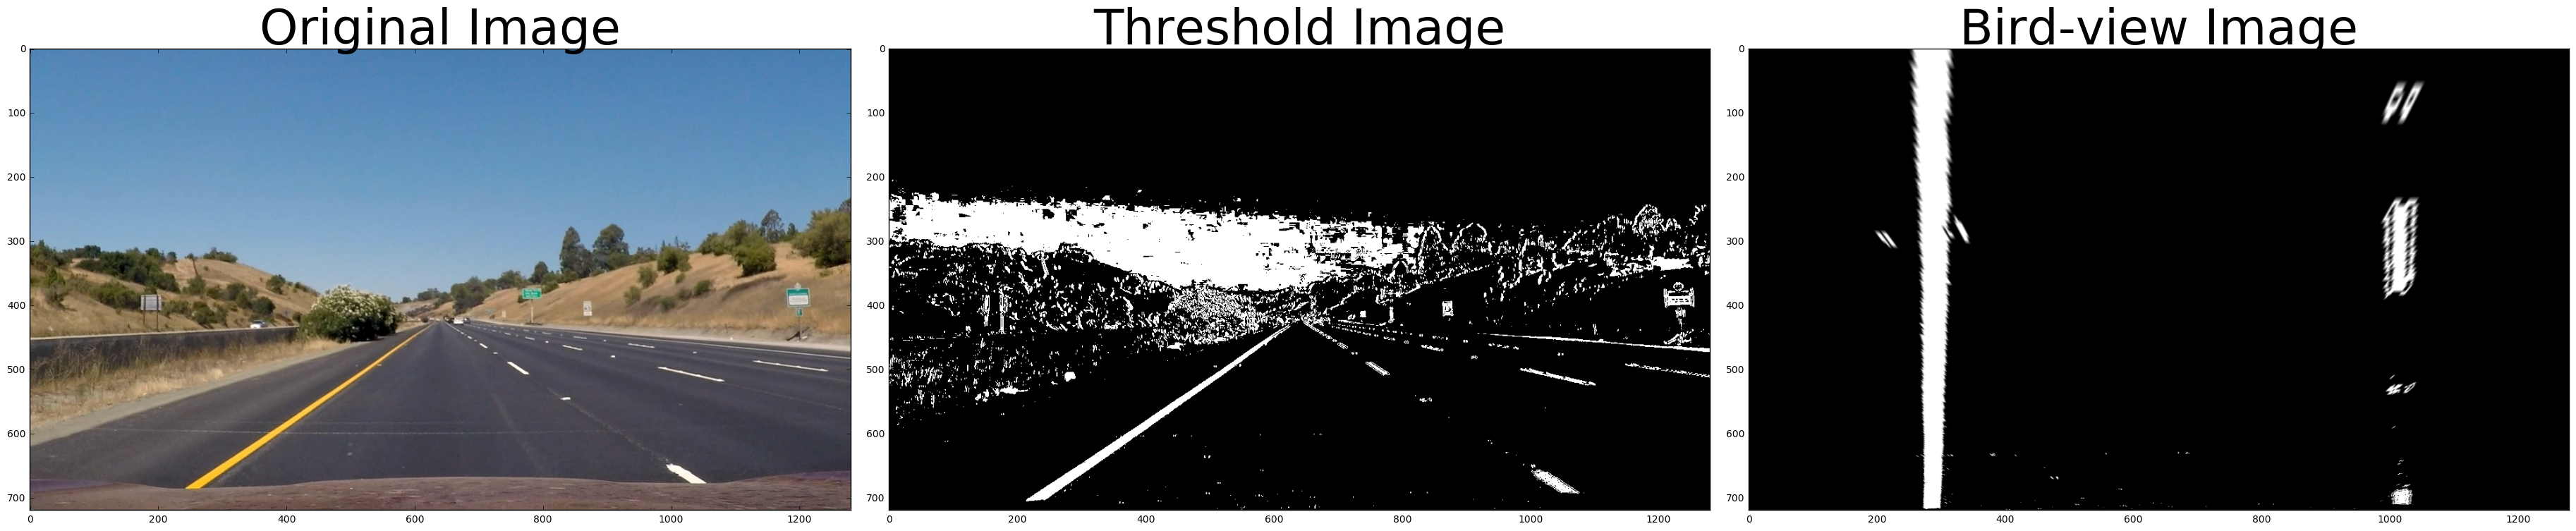

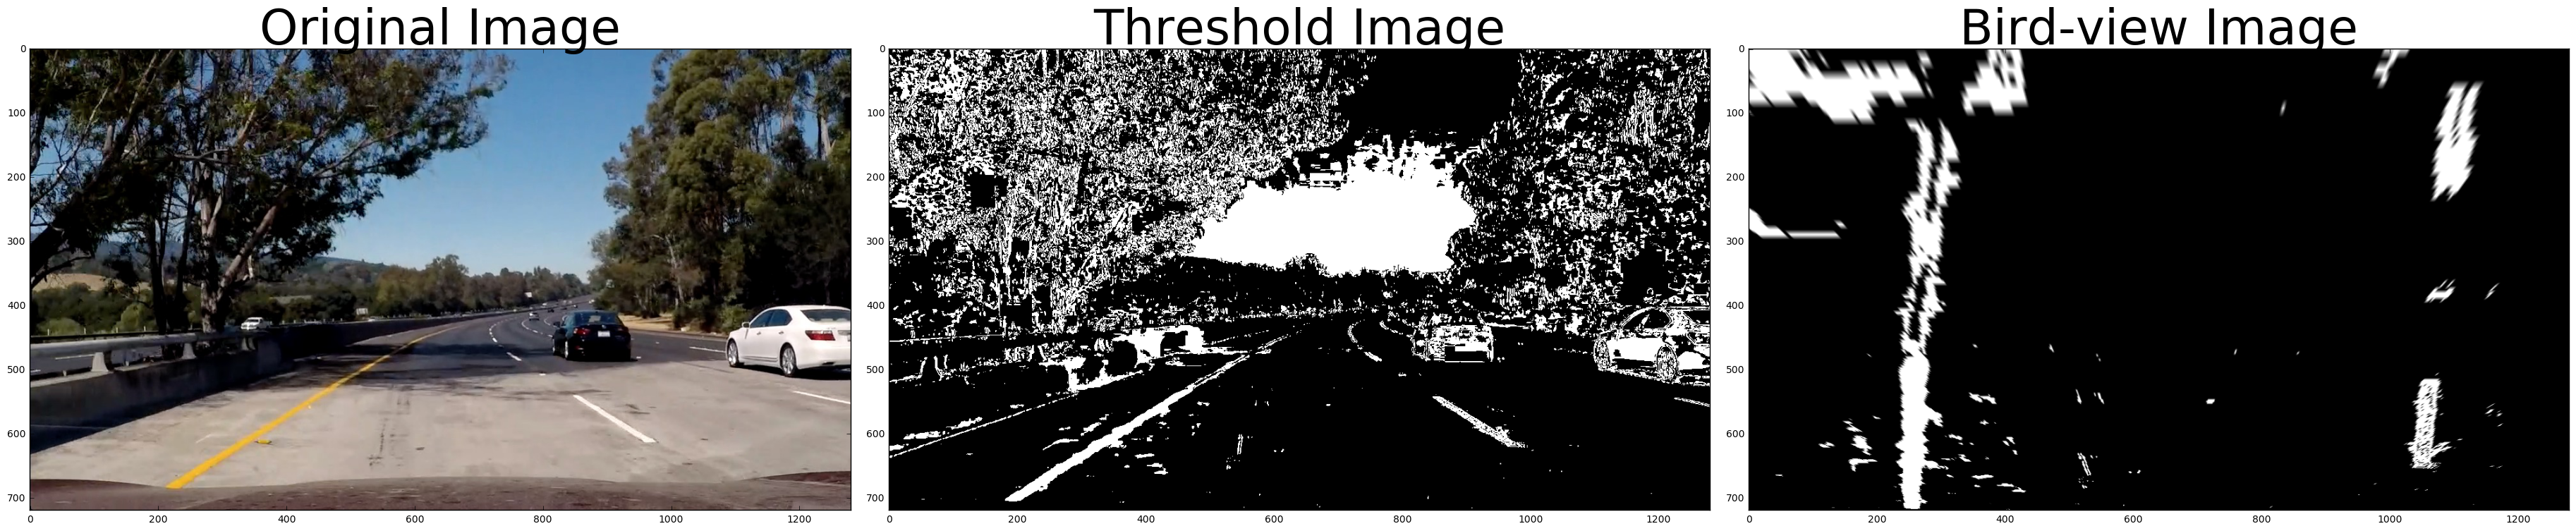

In [8]:
def get_bird_view_image(img_name):
    image_path = os.path.join(test_images_folder_path, img_name)
    image, undistorted = undistort_image(image_path)
    
    _, _, new_binary_image = threshold_image(undistorted)
    _, warped_image = get_region_of_interest(new_binary_image, show_roi=False)
    
    print(warped_image.shape)
    output_image_path = os.path.join(output_folder_path, 'bv_'+img_name)
    mpimg.imsave(output_image_path, warped_image, cmap="gray")
    
    plt.figure();
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(36, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(new_binary_image, cmap='gray')
    ax2.set_title('Threshold Image', fontsize=50)
    ax3.imshow(warped_image, cmap='gray')
    ax3.set_title('Bird-view Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
get_bird_view_image('straight_lines1.jpg')
get_bird_view_image('test5.jpg')

Find lines using convolution approach

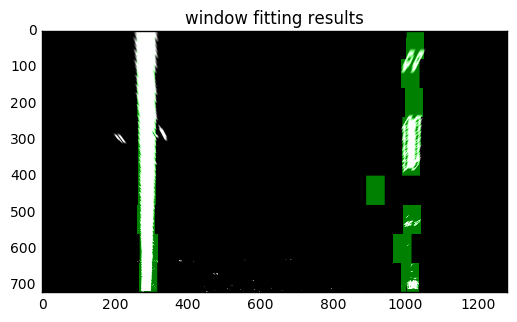

101985.866069 1879.12908345


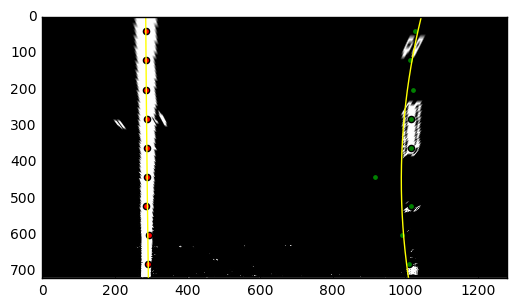

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height)
           ,max(0, int(center-width/2)):min(int(center+width/2), img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    y_values = []
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    y_values.append(warped.shape[0]-int(window_height/2))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),
                                    :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(min(l_center+offset+margin, warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin, 0))
        r_max_index = int(min(r_center+offset+margin, warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        y_values.append(int(warped.shape[0]-(level+0.5)*window_height))

    return window_centroids, y_values

def draw_result(warped, window_centroids, window_width, window_height):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points, np.uint8)
        zero_channel = np.zeros_like(template)
        # make window pixels green
        template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8) 
        # making the original road pixels 3 color channels
        warpage = np.array(cv2.merge((warped, warped, warped)), np.uint8) 
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    else: # If no window centers found, just display orginal road image
        output = np.array(cv2.merge((warped, warped, warped)), np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()

def fit_polynmial(warped, x_centroids, y_values):
    left_x = np.array(x_centroids)[:, 0]
    right_x = np.array(x_centroids)[:, 1]
    left_fit = np.polyfit(y_values, left_x, 2)
    right_fit = np.polyfit(y_values, right_x, 2)
    
    image_height = warped.shape[0]
    plot_y = np.linspace(0, image_height - 1, image_height)
    left_fit_x = left_fit[0]*plot_y**2+left_fit[1]*plot_y+left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2+right_fit[1]*plot_y+right_fit[2]
    
    y_eval = np.max(y_values)
    left_curverad = ((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    
    output = np.dstack((warped, warped, warped))
    plt.imshow(output)
    plt.plot(left_fit_x, plot_y, color='yellow')
    plt.plot(right_fit_x, plot_y, color='yellow')
    plt.scatter(left_x, y_values, c='red')
    plt.scatter(right_x, y_values, c='green')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return plot_y, left_fit_x, right_fit_x

# Read in a thresholded image
#image_path = os.path.join(test_images_folder_path, 'warped-example.jpg')
#warped = mpimg.imread(image_path)
image_path = os.path.join(output_folder_path, 'bv_straight_lines1.jpg')
warped = cv2.imread(image_path, 0)
plt.figure()
plt.imshow(warped)

#get_bird_view_image('test5.jpg')
window_centroids, y_values = find_window_centroids(warped, window_width, window_height, margin)
draw_result(warped, window_centroids, window_width, window_height)
plot_y, left_plot_x, right_plot_x = fit_polynmial(warped, window_centroids, y_values)

Display line back on original image

[[292 680]
 [293 600]
 [286 520]
 [288 440]
 [289 360]
 [289 280]
 [287 200]
 [285 120]
 [285  40]]


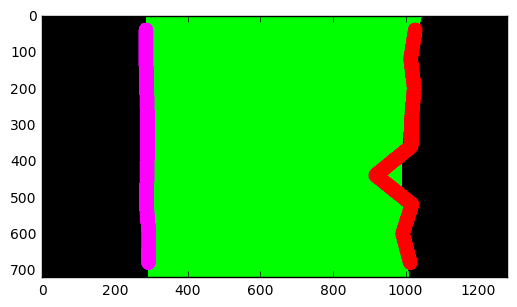

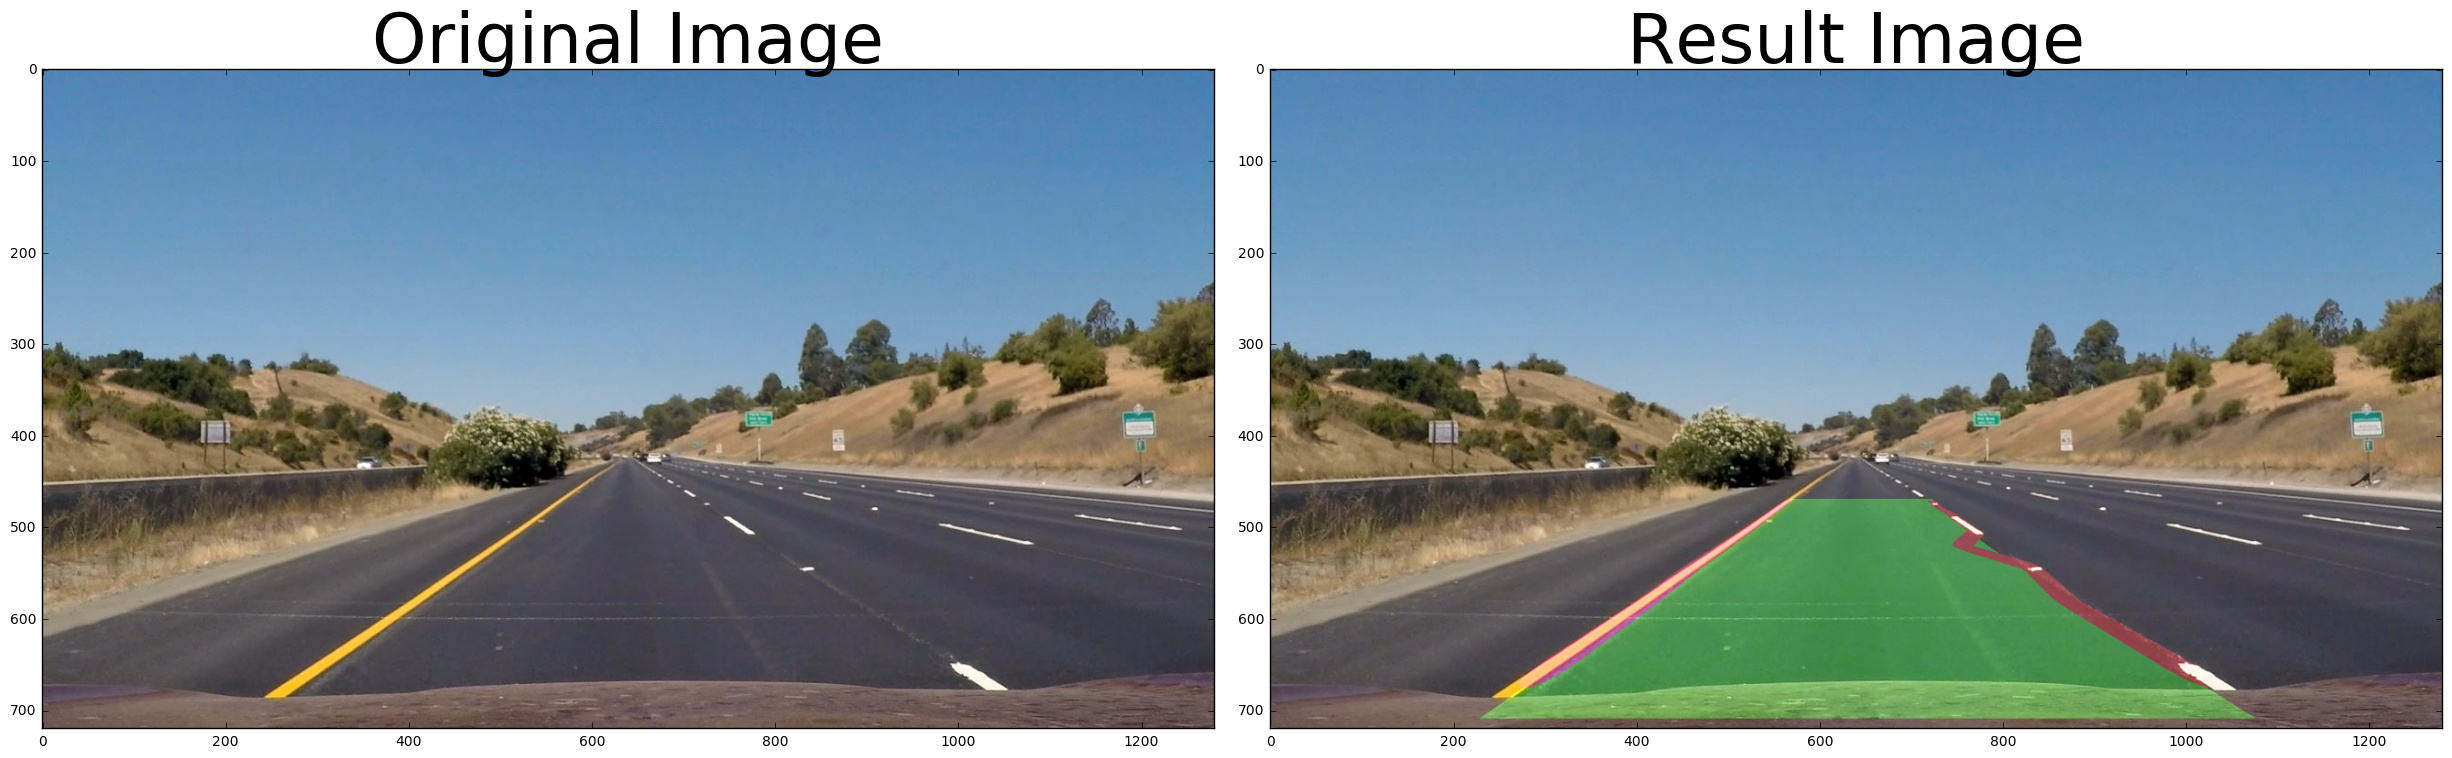

In [30]:
def draw_line_area(undistorted, warped, plot_y, left_plot_x, right_plot_x, x_centroids, y_values):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_plot_x, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_plot_x, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    left_line = np.stack((np.array(x_centroids, dtype=np.int32)[:, 0], y_values), axis=-1)
    right_line = np.stack((np.array(x_centroids, dtype=np.int32)[:, 1], y_values), axis=-1)
    
    print(left_line)
     
    color_warp = cv2.polylines(color_warp, [left_line], False, (255, 0, 255), thickness=40)
    color_warp = cv2.polylines(color_warp, [right_line], False, (255, 0, 0), thickness=40)
    plt.figure();
    plt.imshow(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    height = warped.shape[0]
    width = warped.shape[1]
    src, dst = get_source_destination_points(width, height)
    M = cv2.getPerspectiveTransform(dst, src.astype(np.float32))
    
    new_warp = cv2.warpPerspective(color_warp, M, (width, height))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, new_warp, 0.3, 0)
    
    plt.figure();
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undistorted)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(result)
    ax2.set_title('Result Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

image_path = os.path.join(output_folder_path, 'bv_straight_lines1.jpg')
warped = cv2.imread(image_path, 0)
image_path = os.path.join(test_images_folder_path, 'straight_lines1.jpg')
image = mpimg.imread(image_path, 0)
draw_line_area(image, warped, plot_y, left_plot_x, right_plot_x, window_centroids, y_values)